In [1]:
#Importamos modulos
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
import io
import requests
import seaborn as sns
import timeit
import math
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics

#from google.colab import files
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#Parámetros para visualización
sns.set(style='whitegrid', color_codes=True) #whitegrid #darkgrid

In [2]:
def round_int (y):
    y = np.rint(y) # round
    y = y.astype(int)
    return y

In [3]:
#Para conversiones entre nombres y códigos iso de las comunidades autónomas
df_ccaa = pd.DataFrame({'ccaa_iso':['ES-AN','ES-AR','ES-AS','ES-IB','ES-CN','ES-CB','ES-CL','ES-CM','ES-CT','ES-VC','ES-EX','ES-GA','ES-MD','ES-MC','ES-NC','ES-PV','ES-RI','ES-CE','ES-ML'],
                        'ccaa_nombre':['Andalucía','Aragón','Asturias, Principado de','Balears, Illes','Canarias','Cantabria','Castilla y León','Castilla - La Mancha',
                                  'Cataluña','Comunitat Valenciana', 'Extremadura', 'Galicia', 'Madrid, Comunidad de','Murcia, Región de','Navarra, Comunidad Foral de',
                                  'País Vasco', 'Rioja, La', 'Ceuta', 'Melilla']})

dict_nombre_iso=df_ccaa.set_index('ccaa_iso')['ccaa_nombre'].to_dict()
#dict_nombre_iso


In [19]:
import decimal
def split_train_test (dataset):
    df_train=dataset[dataset['fecha'].isin (pd.date_range (train_ini,train_fin))]
    df_test=dataset[dataset['fecha'].isin (pd.date_range (test_ini,test_fin))]

    train,test =df_train.copy(),df_test.copy()

    train,test =train.drop (['fecha'], axis=1),test.drop (['fecha'], axis=1)
    X_train, y_train=train.drop('casos', axis=1), train['casos']
    X_test, y_test = test.drop('casos', axis=1), test['casos']
    return (X_train, y_train, X_test, y_test)
def metricas_error (real,predict, name_col=''):
    #bias = np.mean(real - predict)
    mae= metrics.mean_absolute_error(real, predict)
    #mse=metrics.mean_squared_error(real, predict)
    rmse= np.sqrt (metrics.mean_squared_error(real, predict))   
    #mape = np.mean(np.abs((real - predict) / real) * 100)   
    score= metrics.r2_score(real,predict) 
    
    df = pd.DataFrame([mae, rmse, score], index=['MAE','RMSE','SCORE'], columns=[name_col])
    return df.T

def fit_model (model, title, show_error=True):
    model.fit (X=X_train,y=y_train)
    predict=model.predict (X_test)
    error_train=metricas_error(y_train, model.predict (X_train),title)
    error_test=metricas_error(y_test, predict,title)
    if show_error== True:
        #display(error_train)
        display(error_test)
    return (model, predict)

def show_error_for_ca(y_pred_rfr,y_pred_xgbr,y_pred_gbr,y_pred_abr,dataset,criterion='rmse'):
    df = dataset[dataset['fecha'].isin (pd.date_range (test_ini,test_fin))]

    df['predict_XGBoost']=round_int (y_pred_xgbr)
    df['predict_AdaBoost']=round_int (y_pred_abr)
    df['predict_RandomForest']=round_int (y_pred_rfr)
    df['predict_GradientBoosting']=round_int (y_pred_gbr)
    best_model={}
    best_error=0
    for ca in df['ccaa_iso'].unique():
        df_ca = df[df['ccaa_iso']==ca]
        #print (dict_nombre_iso[ccaa_iso_inv[ca]])
        if criterion == 'mae':
            #XGBoost
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_XGBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_XGBoost']))
            best_error=mae
            best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'XGBoost', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }
            #AdaBoost
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_AdaBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_XGBoost']))
            if mae<best_error:
                best_error=mae
                best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'AdaBoost', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }
            #RandomForest
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_RandomForest'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_RandomForest']))
            if mae<best_error:
                best_error=mae
                best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'RandomForest', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }
            #GradientBoosting
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_GradientBoosting'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_GradientBoosting']))
            if mae<best_error:
                best_error=mae
                best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'GradientBoosting', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }
        else:
            #XGBoost
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_XGBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_XGBoost']))
            score= metrics.r2_score(df_ca['casos'], df_ca['predict_XGBoost']) 
            #print ('XGBoost: MAE:', mae, 'RMSE:', rmse)
            best_error=rmse
            best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'XGBoost', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }
            #AdaBoost
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_AdaBoost'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_AdaBoost']))
            score= metrics.r2_score(df_ca['casos'], df_ca['predict_AdaBoost']) 
            #print ('AdaBoost: MAE:', mae, 'RMSE:', rmse)
            if rmse<best_error:
                best_error=rmse
                best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'AdaBoost', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }
            #RandomForest
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_RandomForest'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_RandomForest']))
            score= metrics.r2_score(df_ca['casos'], df_ca['predict_RandomForest'])
            #print ('RandomForest: MAE:', mae, 'RMSE:', rmse)
            if rmse<best_error:
                best_error=rmse
                best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'RandomForest', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }
            #GradientBoosting
            mae= metrics.mean_absolute_error(df_ca['casos'], df_ca['predict_GradientBoosting'])
            rmse= np.sqrt (metrics.mean_squared_error(df_ca['casos'], df_ca['predict_GradientBoosting'])) 
            score= metrics.r2_score(df_ca['casos'], df_ca['predict_GradientBoosting'])
            #print ('GradientBoosting: MAE:', mae, 'RMSE:', rmse)
            if rmse<best_error:
                best_error=rmse
                best_model[ca]={'ccaa_nombre':dict_nombre_iso[ccaa_iso_inv[ca]], 'ccaa_iso':ca, 'Modelo':'GradientBoosting', 'MAE':round (mae,3), 'RMSE':round (rmse,3) }

    best_model=pd.DataFrame (best_model).T
    display(best_model)
    return (best_model)

def plot_best_model (predict_rfr, predict_xgbr, predict_gbr, predict_abr, best_models,dataset):
    df = dataset[dataset['fecha'].isin (pd.date_range (test_ini,test_fin))]
    df['XGBoost']=round_int (predict_xgbr)
    df['AdaBoost']=round_int (predict_abr)
    df['RandomForest']=round_int (predict_rfr)
    df['GradientBoosting']=round_int (predict_gbr)

    #Calculamos filas y columnas del Grid
    n=df.ccaa_iso.nunique()
    ncols=2
    nfilas=math.ceil((n-ncols)/ncols)+1

    #Definimos la grid para representación
    fig= plt.figure(figsize=(20,42))
    gs = fig.add_gridspec(nfilas, ncols,hspace=0.4)

    #fig.suptitle('Predicción de casos por CA')
    nf,nc=0,0
    for ca in df['ccaa_iso'].unique():
        ax=fig.add_subplot(gs[nf,nc])

        x = df[df['ccaa_iso']== ca]['fecha']
        y1 = df[df['ccaa_iso']== ca]['casos'].cumsum()
        model_for_ca=best_models[best_models['ccaa_iso']==ca]['Modelo'].values[0]
        y2 = df[df['ccaa_iso']== ca][model_for_ca].cumsum()

        ax.plot (x, y1, label='Real',linewidth=2.5)
        ax.plot (x, y2, label =model_for_ca,linewidth=2.5)
        ax.set_ylabel ('Número de casos acumulados')
        ax.set_title ( dict_nombre_iso[ccaa_iso_inv[ca]],weight='bold', size=15)
        ax.tick_params(axis='x', labelsize=12, labelcolor='black')
        ax.tick_params(axis='y', labelsize=12,  labelcolor='black')
        ax.legend()
        if (nc == (ncols-1)): 
            nf=nf+1
            nc=0
        else:
            nc=nc+1


In [5]:
def time_feat(x): 
    x['dia_sem']=x['fecha'].dt.dayofweek  #0-Lunes, 1-Martes, 2-Miércoles, 3-Jueves, 4-Viernes , 5-Sábado y 6-Domingo 
    x['dia_year']=x['fecha'].dt.dayofyear
    x['dia_mes']=x['fecha'].dt.day        
    x['is_weekend']=x['dia_sem'].apply( lambda x : 1 if x in [5,6] else 0 )
    return x 

In [6]:
def model_eval(models):
    train=dataset[dataset['fecha'].isin (pd.date_range (train_ini,train_fin))]
    test=dataset[dataset['fecha'].isin (pd.date_range (test_ini,test_fin))]

    #train,test =train.drop (['fecha'], axis=1),test.drop (['fecha'], axis=1)
    X_train, y_train=train.drop(['casos','fecha'], axis=1), train['casos']
    X_test, y_test = test.drop(['casos','fecha'], axis=1), test['casos']
    
    models_result=dict()
    models_fit=dict()
    for key,model in models.items():
        model.fit (X=X_train,y=y_train)
        predict=model.predict (X_test)
        mae= metrics.mean_absolute_error(y_test, predict)
        rmse= np.sqrt (metrics.mean_squared_error(y_test, predict))   
        score= metrics.r2_score(y_test,predict) 
        models_result[key]={'MAE':mae, 'RMSE':rmse, 'SCORE':score }
        models_fit[key]=model
    return (models_result, models_fit)

# Procesamiento dataset único


In [39]:
# Lectura del dataset
covid = pd.read_csv('../datasets/covid_dataset.csv', ',', index_col='Unnamed: 0')
covid.reset_index (drop=True, inplace=True)
#covid["fecha"] = pd.to_datetime(covid.fecha)
covid["fecha"] = pd.to_datetime(covid.fecha)

In [40]:
covid.columns

Index(['ccaa_iso', 'fecha', 'casos', 'num_casos_prueba_pcr',
       'num_casos_prueba_test_ac', 'num_casos_prueba_otras',
       'num_casos_prueba_desconocida', 'ccaa_nombre', 'ocio', 'compra',
       'parques', 'transporte', 'trabajo', 'residencial', 'reuniones',
       'host_int', 'host_ext', 'aforo_comercial', 'ocio_nocturno', 'Pob',
       'Sup', 'Densidad'],
      dtype='object')

In [41]:
#Codificación del atributo ccaa_iso como numérico y construcción de un diccionario para transformación inversa
le = preprocessing.LabelEncoder()
covid['ccaa_iso_txt']=covid['ccaa_iso']
covid['ccaa_iso']= le.fit_transform(covid['ccaa_iso'])

#Para obtener el diccionario invertido de la transformación de ccaa_iso. Para visualización
number_c = covid['ccaa_iso']
ccaa_iso = le.inverse_transform(covid['ccaa_iso'])
ccaa_iso_inv = dict(zip(number_c,ccaa_iso))
#Desglose del campo fecha en componentes tales como día de la semana, día del mes,...
time_feat(covid)

,ccaa_iso,fecha,casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida,ccaa_nombre,ocio,compra,...,aforo_comercial,ocio_nocturno,Pob,Sup,Densidad,ccaa_iso_txt,dia_sem,dia_year,dia_mes,is_weekend
0,0,2020-01-31,0,0,0,0,0,Andalucía,5.0,-1.0,...,1.00,1.00,8414240.0,87588.45,96.065634,ES-AN,4,31,31,0
1,1,2020-01-31,0,0,0,0,0,Aragón,3.0,7.0,...,1.00,1.00,1319291.0,47698.07,27.659211,ES-AR,4,31,31,0
2,2,2020-01-31,0,0,0,0,0,Principado de Asturias,0.0,-1.0,...,1.00,1.00,1022800.0,10597.42,96.514057,ES-AS,4,31,31,0
3,3,2020-01-31,0,0,0,0,0,Cantabria,6.0,4.0,...,1.00,1.00,581078.0,5261.12,110.447585,ES-CB,4,31,31,0
4,4,2020-01-31,0,0,0,0,0,Ceuta,-3.0,-6.0,...,1.00,1.00,84777.0,19.87,4266.582788,ES-CE,4,31,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,14,2020-08-23,13,12,0,0,1,Melilla,-21.0,-22.0,...,0.75,0.75,86487.0,14.24,6073.525281,ES-ML,6,236,23,1
3910,15,2020-08-23,70,70,0,0,0,Comunidad Foral de Navarra,-15.0,-1.0,...,0.75,0.75,654214.0,9801.01,66.749651,ES-NC,6,236,23,1
3911,16,2020-08-23,636,636,0,0,0,País Vasco,-36.0,-12.0,...,1.00,0.60,2207776.0,7091.91,311.309083,ES-PV,6,236,23,1
3912,17,2020-08-23,63,63,0,0,0,La Rioja,-10.0,3.0,...,1.00,0.75,316798.0,5027.69,63.010647,ES-RI,6,236,23,1


In [42]:
feat=['ccaa_iso', 'fecha', 'dia_sem','dia_year','dia_mes','is_weekend','ocio', 'compra', 'parques',
       'transporte', 'trabajo', 'residencial', 'reuniones',
       'host_int', 'host_ext', 'aforo_comercial', 'ocio_nocturno','casos','Densidad' ]
cols_movilidad=['parques','ocio','compra','transporte','trabajo','residencial']
cols_restricciones=['reuniones','host_int','host_ext','aforo_comercial','ocio_nocturno']

Selección de características útiles para aplicar a la fase de modelado

In [43]:
dataset=covid[feat]

# División en train y test

In [44]:
min_fecha=dataset.fecha.min()
max_fecha=dataset.fecha.max()
print (min_fecha, ':', max_fecha)

2020-01-31 00:00:00 : 2020-08-23 00:00:00


In [45]:
train_ini=min_fecha
train_fin='2020-07-14'
test_ini='2020-07-15'
test_fin= max_fecha

In [46]:
dataset=covid[feat]
dataset.columns

Index(['ccaa_iso', 'fecha', 'dia_sem', 'dia_year', 'dia_mes', 'is_weekend',
       'ocio', 'compra', 'parques', 'transporte', 'trabajo', 'residencial',
       'reuniones', 'host_int', 'host_ext', 'aforo_comercial', 'ocio_nocturno',
       'casos', 'Densidad'],
      dtype='object')

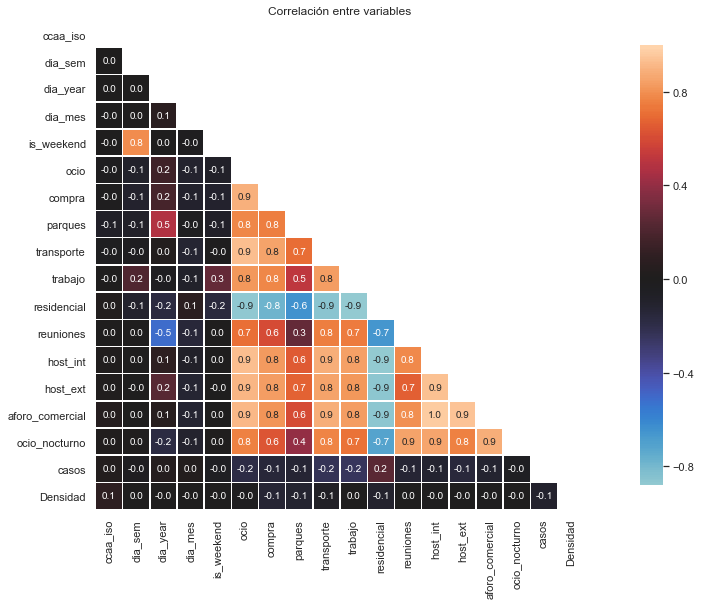

In [47]:
#Correlaciones entre las variables y el número de casos 
corr = dataset.corr()
f, ax = plt.subplots(figsize=(20, 9))
#plt.suptitle ( 'Matriz de correlación')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap="GnBu"
#ax=plt.subplot (211)
plt.title('Correlación entre variables')
#ax.set_title='Matriz de correlación '
sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5,fmt='.1f',cbar_kws={"shrink": 0.9},ax=ax,annot=True)




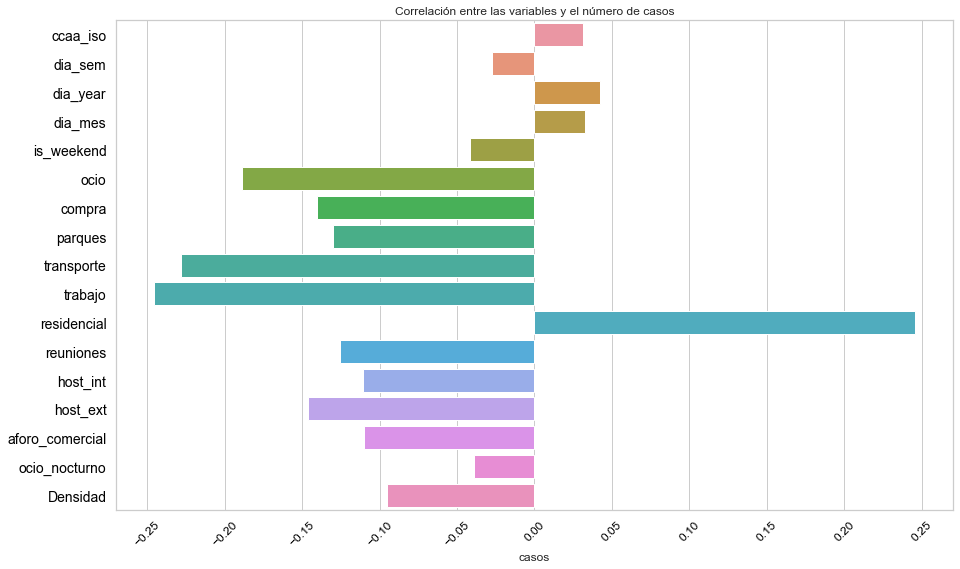

In [48]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Correlaciones entre las variables y el número de casos 
corr = dataset.corr()
f, ax = plt.subplots(figsize=(15, 9))
plt.title('Correlación entre las variables y el número de casos')
ax=plt.subplot()
ax.set_title ('Correlación entre las variables y el número de casos')
corr = dataset.corr().drop(['casos'], axis=0)
sns.barplot(x=corr['casos'], y=corr.index, ax=ax)
ax.tick_params(axis='x', labelsize=12, labelrotation=45, labelcolor='black')
ax.tick_params(axis='y', labelsize=14,labelcolor='black')
ax.xaxis.set_major_locator(MultipleLocator(0.05))


In [49]:
def model_eval(models, dataset):
    train=dataset[dataset['fecha'].isin (pd.date_range (train_ini,train_fin))]
    test=dataset[dataset['fecha'].isin (pd.date_range (test_ini,test_fin))]
    #train=train.reset_index()
    #test=test.reset_index()

    #train,test =train.drop (['fecha'], axis=1),test.drop (['fecha'], axis=1)
    X_train, y_train=train.drop(['casos','fecha'], axis=1), train['casos']
    X_test, y_test = test.drop(['casos','fecha'], axis=1), test['casos']
    
    models_error=dict()
    models_fit=dict()
    models_predict=dict()
    for key,model in models.items():
        model.fit (X=X_train,y=y_train)
        predict=model.predict (X_test)
        #bias = np.mean(y_test - predict)
        mae= metrics.mean_absolute_error(y_test, predict)
        rmse= np.sqrt (metrics.mean_squared_error(y_test, predict))   
        score= metrics.r2_score(y_test,predict) 
        models_error[key]={'MAE':round (mae,3), 'RMSE':round (rmse,3), 'SCORE':round(score,3)  }
        models_predict[key]=predict
        models_fit[key]=model
    return (models_fit, models_predict,models_error)

## LINEA BASE-Parametrización por defecto

In [50]:
models=dict()
models['RF']= RandomForestRegressor(random_state=0, criterion='mse')
models['XGB']= XGBRegressor(eval_metric='rmse',objective='reg:squarederror',random_state=0)
models['GB']= GradientBoostingRegressor(random_state=0,criterion='mse')
models['AB']= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'), random_state=0)
models_fit_01, models_predict_01, models_error_01=model_eval (models,dataset)
resultado=pd.DataFrame (models_error_01).T
display(resultado)

,MAE,RMSE,SCORE
RF,146.373,316.073,0.119
XGB,163.899,332.304,0.026
GB,164.595,330.377,0.038
AB,143.583,312.704,0.138


# Transformación de características


## 02-Casos previos

In [51]:
dataset=covid[feat]
dataset.columns

Index(['ccaa_iso', 'fecha', 'dia_sem', 'dia_year', 'dia_mes', 'is_weekend',
       'ocio', 'compra', 'parques', 'transporte', 'trabajo', 'residencial',
       'reuniones', 'host_int', 'host_ext', 'aforo_comercial', 'ocio_nocturno',
       'casos', 'Densidad'],
      dtype='object')

In [52]:
for lag in range(7,22):
    dataset['casos_t-'+str(lag)]=dataset.groupby(['ccaa_iso'])['casos'].shift(lag, fill_value=0)
dataset.fillna(0, inplace=True)

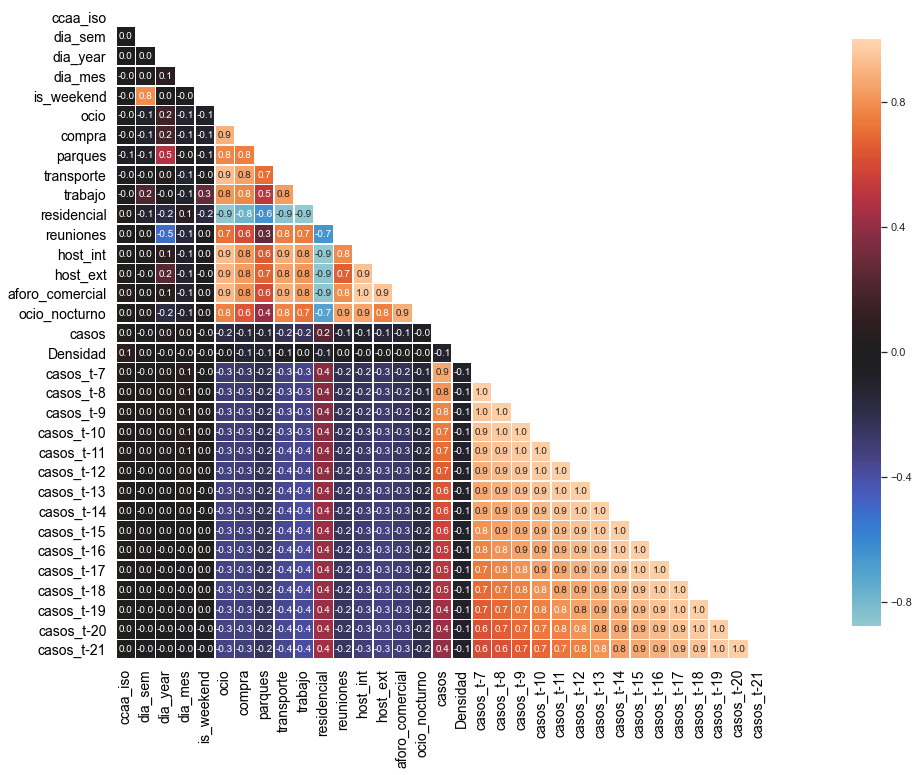

In [53]:
#Correlaciones entre las variables y el número de casos

#df=dataset[dataset['fecha'].isin (pd.date_range (train_ini,train_fin))]

corr = dataset.corr()
f, ax = plt.subplots(figsize=(30, 12))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap="GnBu"
ax=plt.subplot ()
#ax.title='Matriz de correlación '

sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5,fmt='.1f',cbar_kws={"shrink": 0.9},ax=ax,annot=True)

ax.tick_params(axis='x', labelsize=14, labelcolor='black')
ax.tick_params(axis='y', labelsize=14,  labelcolor='black')


In [54]:
models=dict()
models['RF']= RandomForestRegressor(random_state=0, criterion='mse')
models['XGB']= XGBRegressor(eval_metric='rmse',objective='reg:squarederror',random_state=0)
models['GB']= GradientBoostingRegressor(random_state=0,criterion='mse')
models['AB']= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'), random_state=0)
models_fit_02, models_predict_02, models_error_02=model_eval (models,dataset)
resultado=pd.concat ([resultado, 
                        pd.DataFrame (models_error_02).T], axis=1)
resultado

,MAE,RMSE,SCORE,MAE,RMSE,SCORE
RF,146.373,316.073,0.119,86.949,198.779,0.652
XGB,163.899,332.304,0.026,74.450,183.938,0.702
GB,164.595,330.377,0.038,70.175,169.517,0.747
AB,143.583,312.704,0.138,96.517,211.357,0.606


In [55]:
best_models=show_error_for_ca(models_predict_02['RF'],
                  models_predict_02['XGB'],
                  models_predict_02['GB'],
                  models_predict_02['AB'],covid,criterion='rmse')

,ccaa_nombre,ccaa_iso,Modelo,MAE,RMSE
0,Andalucía,0,GradientBoosting,67.25,83.328
1,Aragón,1,RandomForest,95.475,121.792
2,"Asturias, Principado de",2,AdaBoost,9.75,14.773
3,Cantabria,3,RandomForest,15.825,22.693
4,Ceuta,4,AdaBoost,1.875,2.752
5,Castilla y León,5,XGBoost,48.375,64.329
6,Castilla - La Mancha,6,XGBoost,28.8,45.022
7,Canarias,7,XGBoost,34.075,47.207
8,Cataluña,8,GradientBoosting,225.975,255.975
9,Extremadura,9,AdaBoost,10.575,14.101


## 03-Iteración 2. Retraso en las características de movilidad

In [56]:
for col in cols_movilidad:
    dataset[col+'_t-7'] = dataset.groupby(['ccaa_iso'])[col].shift(7)
    dataset[col+'_t-14'] = dataset.groupby(['ccaa_iso'])[col].shift(14)
    dataset[col+'_t-21'] = dataset.groupby(['ccaa_iso'])[col].shift(21)
    dataset[col+'_t-28'] = dataset.groupby(['ccaa_iso'])[col].shift(28)
    
dataset.fillna(0, inplace=True)

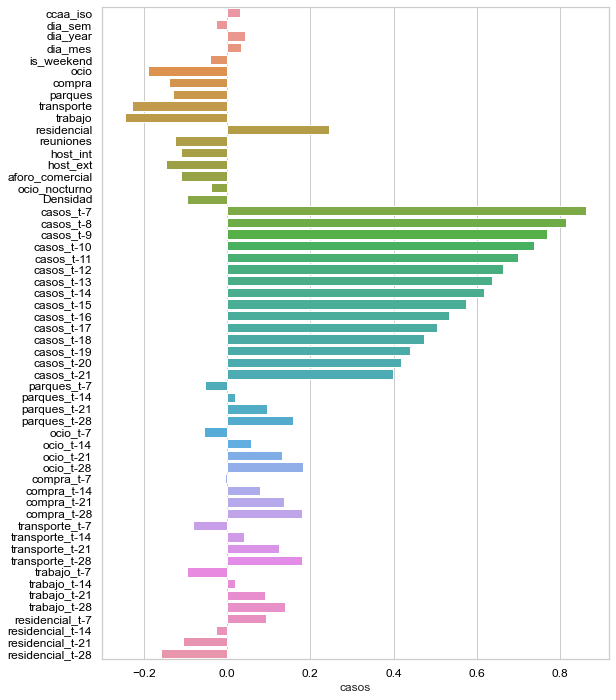

In [57]:
#Correlaciones entre las variables y el número de casos
corr = dataset.corr()
f, ax = plt.subplots(figsize=(20, 12))

mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap="GnBu"
ax=plt.subplot (111)
sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5,fmt='.1f',cbar_kws={"shrink": 0.9},ax=ax,annot=True)

ax=plt.subplot (122)
corr = dataset.corr().drop(['casos'], axis=0)
#ax.set_title('Correlación con el número de casos en datos de entrenamiento')
sns.barplot(x=corr['casos'], y=corr.index)
ax.tick_params(axis='x', labelsize=12, labelcolor='black')
ax.tick_params(axis='y', labelsize=12,  labelcolor='black')

In [58]:
models=dict()
models['RF']= RandomForestRegressor(random_state=0, criterion='mse')
models['XGB']= XGBRegressor(eval_metric='rmse',objective='reg:squarederror',random_state=0)
models['GB']= GradientBoostingRegressor(random_state=0,criterion='mse')
models['AB']= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'), random_state=0)
models_fit_03, models_predict_03, models_error_03=model_eval (models,dataset)
resultado=pd.concat ([resultado,
                      pd.DataFrame (models_error_03).T],axis=1)
resultado

,MAE,RMSE,SCORE,MAE,RMSE,SCORE,MAE,RMSE,SCORE
RF,146.373,316.073,0.119,86.949,198.779,0.652,122.260,246.753,0.463
XGB,163.899,332.304,0.026,74.450,183.938,0.702,80.816,170.703,0.743
GB,164.595,330.377,0.038,70.175,169.517,0.747,83.308,170.669,0.743
AB,143.583,312.704,0.138,96.517,211.357,0.606,93.779,187.357,0.690


In [59]:
best_models=show_error_for_ca(models_predict_03['RF'],
                  models_predict_03['XGB'],
                  models_predict_03['GB'],
                  models_predict_03['AB'],covid,criterion='rmse')

,ccaa_nombre,ccaa_iso,Modelo,MAE,RMSE
0,Andalucía,0,AdaBoost,48.25,65.517
1,Aragón,1,XGBoost,146.125,182.806
2,"Asturias, Principado de",2,GradientBoosting,23.25,35.388
3,Cantabria,3,RandomForest,52.075,66.709
4,Ceuta,4,AdaBoost,1.45,2.655
5,Castilla y León,5,XGBoost,124.175,187.436
6,Castilla - La Mancha,6,AdaBoost,53.3,89.177
7,Canarias,7,XGBoost,38.225,52.329
8,Cataluña,8,XGBoost,140.125,165.714
9,Extremadura,9,GradientBoosting,14.775,19.493


## 04-Iteración 3 - Retraso para medidas de las fases de desescalada

In [60]:
for col in cols_restricciones:
    dataset[col+'_t-7'] = dataset.groupby(['ccaa_iso'])[col].shift(7)
    dataset[col+'_t-14'] = dataset.groupby(['ccaa_iso'])[col].shift(14)
    dataset[col+'_t-21'] = dataset.groupby(['ccaa_iso'])[col].shift(21)
    
dataset.fillna(0, inplace=True)


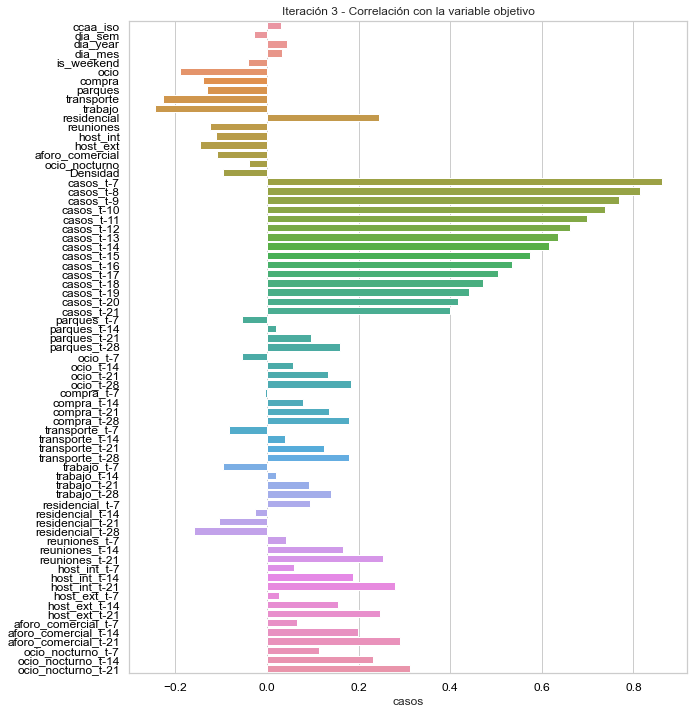

In [61]:
#Correlaciones entre las variables y el número de casos

corr = dataset.corr()
f, ax = plt.subplots(figsize=(10, 12))

#mask = np.triu(np.ones_like(corr, dtype=np.bool))
#cmap="GnBu"
#ax=plt.subplot (121)
#ax.set_title='Matriz de correlación '
#sns.heatmap(corr, mask=mask, vmax=1, center=0,
#            square=True, linewidths=.5,fmt='.1f',cbar_kws={"shrink": 0.9},ax=ax,annot=False)


ax=plt.subplot ()
corr = dataset.corr().drop(['casos'], axis=0)
ax.set_title('Iteración 3 - Correlación con la variable objetivo')
sns.barplot(x=corr['casos'], y=corr.index)
ax.tick_params(axis='x', labelsize=12, labelcolor='black')
ax.tick_params(axis='y', labelsize=12,  labelcolor='black')
#plt.xlim([-.15, .25])


In [62]:
models=dict()
models['RF']= RandomForestRegressor(random_state=0, criterion='mse')
models['XGB']= XGBRegressor(eval_metric='rmse',objective='reg:squarederror',random_state=0)
models['GB']= GradientBoostingRegressor(random_state=0,criterion='mse')
models['AB']= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'), random_state=0)
models_fit_04, models_predict_04, models_error_04=model_eval (models,dataset)
resultado=pd.concat ([resultado,
                      pd.DataFrame (models_error_04).T],axis=1)
resultado

,MAE,RMSE,SCORE,MAE,RMSE,SCORE,MAE,RMSE,SCORE,MAE,RMSE,SCORE
RF,146.373,316.073,0.119,86.949,198.779,0.652,122.260,246.753,0.463,109.021,213.328,0.599
XGB,163.899,332.304,0.026,74.450,183.938,0.702,80.816,170.703,0.743,73.159,163.599,0.764
GB,164.595,330.377,0.038,70.175,169.517,0.747,83.308,170.669,0.743,80.463,162.787,0.766
AB,143.583,312.704,0.138,96.517,211.357,0.606,93.779,187.357,0.690,93.662,196.866,0.658


In [63]:
best_models=show_error_for_ca(models_predict_04['RF'],
                  models_predict_04['XGB'],
                  models_predict_04['GB'],
                  models_predict_04['AB'],covid,criterion='rmse')

,ccaa_nombre,ccaa_iso,Modelo,MAE,RMSE
0,Andalucía,0,AdaBoost,51.75,66.981
1,Aragón,1,XGBoost,139.85,171.895
2,"Asturias, Principado de",2,AdaBoost,20,28.365
3,Cantabria,3,RandomForest,25.8,31.373
4,Ceuta,4,AdaBoost,1.875,2.894
5,Castilla y León,5,XGBoost,103.6,160.311
6,Castilla - La Mancha,6,AdaBoost,43.825,66.648
7,Canarias,7,AdaBoost,33.875,48.312
8,Cataluña,8,XGBoost,150.075,177.824
9,Extremadura,9,GradientBoosting,12.675,16.111


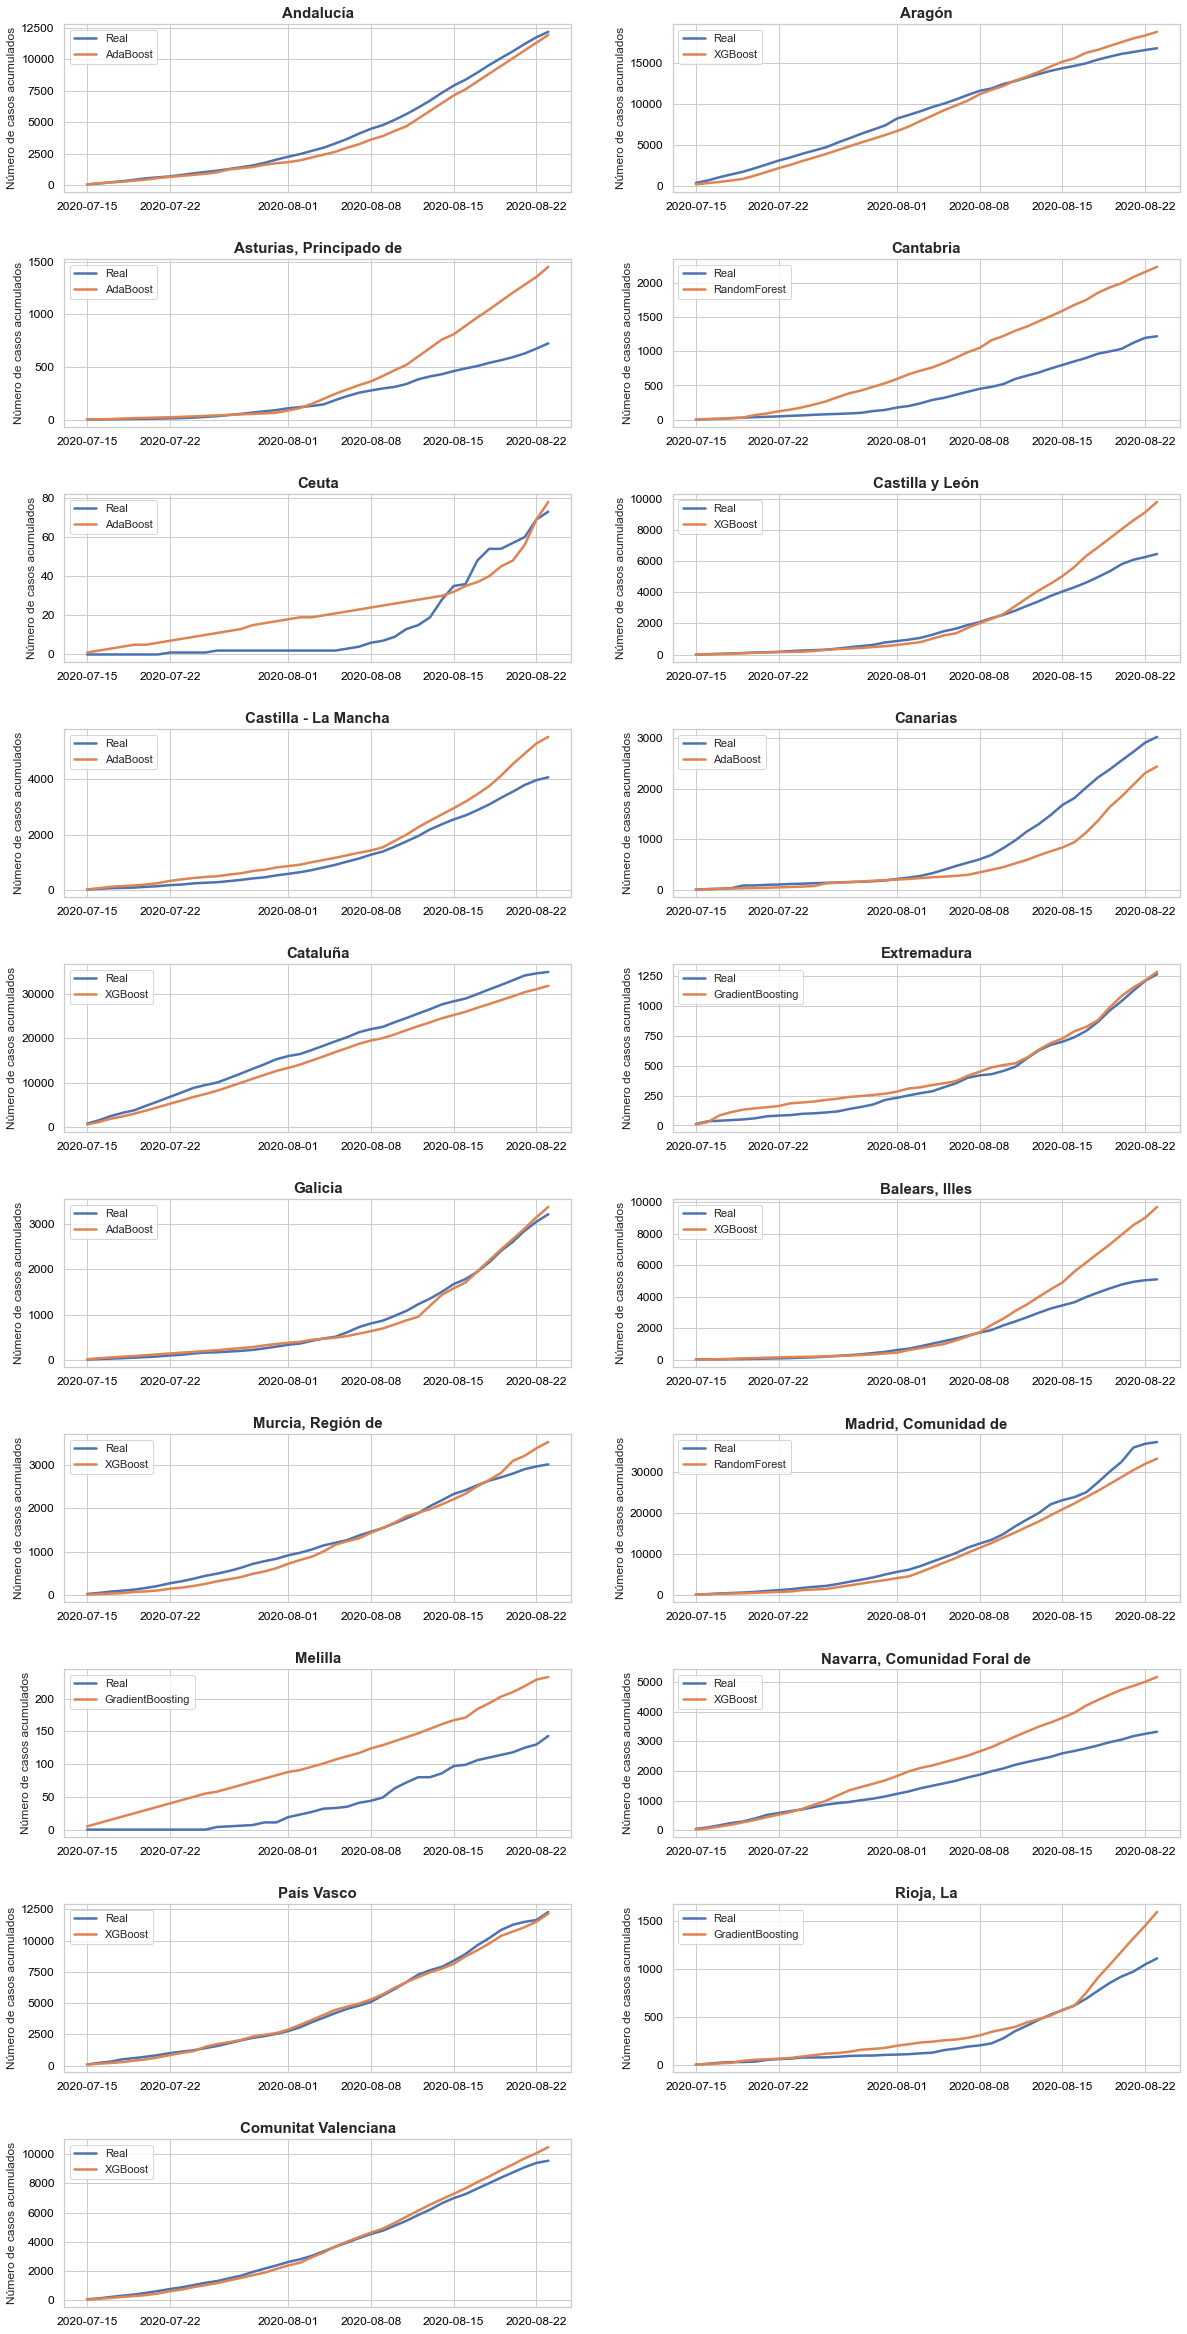

In [64]:
plot_best_model (models_predict_04['RF'],
                  models_predict_04['XGB'],
                  models_predict_04['GB'],
                  models_predict_04['AB'],best_models, covid)

# Ajuste de parámetros 

In [65]:
#from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
def random_tune( model, param, title, show_features_importance=True):

    X_train, y_train, X_test, y_test =split_train_test (dataset)
    #random= RandomizedSearchCV(estimator = model, param_distributions = param, n_iter = 50, scoring='neg_mean_squared_error',cv = 5, random_state=0, n_jobs = -1)
    tscv = TimeSeriesSplit(n_splits=3)
    random= RandomizedSearchCV(estimator = model, param_distributions = param, n_iter = 50, scoring='neg_mean_squared_error',cv = tscv, random_state=0, n_jobs = -1)
    #grid = GridSearchCV(estimator = model, param_grid= hyperparam, cv = tscv, n_jobs=-1, scoring='neg_mean_squared_error')
    random.fit(X = X_train,y=y_train)
    #report(grid.cv_results_, n_top = 5)
    best_params = random.best_params_
    for i in best_params:
        print (i, ":", best_params[i])
    fit_model= random.best_estimator_
    y_pred=fit_model.predict (X_test)
    error_test=metricas_error(y_test, y_pred,title)
    display (error_test)
    return (fit_model, y_pred)
#from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
def grid_tune( model, param, title, show_features_importance=True):

    X_train, y_train, X_test, y_test =split_train_test (dataset)

    tscv = TimeSeriesSplit(n_splits=3)
    #random= RandomizedSearchCV(estimator = model, param_distributions = param, n_iter = 50, scoring='neg_mean_squared_error',cv = tscv, random_state=0, n_jobs = -1)
    grid = GridSearchCV(estimator = model, param_grid= param, cv = tscv, n_jobs=-1, scoring='neg_mean_squared_error')
    grid.fit(X = X_train,y=y_train)
    #report(grid.cv_results_)
    best_params = grid.best_params_
    for i in best_params:
        print (i, ":", best_params[i])
    fit_model= grid.best_estimator_
    y_pred=fit_model.predict (X_test)
    error_test=metricas_error(y_test, y_pred,title)
    display (error_test)
    return (fit_model, y_pred)

## RandomForest

In [66]:
hyperparam = {"n_estimators": [64,100, 128,], 
              "max_depth": [4,6,8], 
              "min_samples_split": [2, 4, 6], 
              "min_samples_leaf": [12, 16,18,20], 
              "bootstrap": [True, False] 
             }
rfr_tune_grid,predict_rfr_tune_grid= grid_tune (RandomForestRegressor(criterion='mse', random_state=0),hyperparam, 'RandomForest')

bootstrap : True
max_depth : 4
min_samples_leaf : 20
min_samples_split : 2
n_estimators : 128


,MAE,RMSE,SCORE
RandomForest,69.682409,159.513472,0.775636


In [379]:
rfr_tune_grid

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=128,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

## XGBoost

In [67]:
XGBRegressor(eval_metric='rmse',objective='reg:squarederror', random_state=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [68]:
hyperparam = {
    'n_estimators': [100,200,500],
    'max_depth':range(1,7),
    'min_child_weight':range(1,5)
}

xgbr_tune_grid,predict_xgbr_tune_grid= grid_tune (XGBRegressor(eval_metric='rmse',objective='reg:squarederror', random_state=0),hyperparam, 'XGBoost')

max_depth : 2
min_child_weight : 1
n_estimators : 100


,MAE,RMSE,SCORE
XGBoost,72.744693,165.712305,0.757859


In [69]:
hyperparam = {
    'subsample': [i / 10.0 for i in range(6, 9)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)]
}

xgbr_tune_grid,predict_xgbr_tune_grid= grid_tune (xgbr_tune_grid,hyperparam, 'XGBoost')

colsample_bytree : 0.8
subsample : 0.8


,MAE,RMSE,SCORE
XGBoost,81.32443,158.836201,0.777537


In [70]:
hyperparam = {
    'eta': [.3, .2, .1, .05, .01, .005],
    'gamma':[i/10.0 for i in range(0,6)]
}
xgbr_tune_grid,predict_xgbr_tune_grid= grid_tune (xgbr_tune_grid,hyperparam, 'XGBoost')

eta : 0.3
gamma : 0.0


,MAE,RMSE,SCORE
XGBoost,81.32443,158.836201,0.777537


## GradientBoosting

In [71]:
hyperparam = {
 "n_estimators": [64,100,200],
 "learning_rate" : [0.01, 0.05,0.1,0.25,0.5],
 "max_features" : ["auto", "sqrt"],
 "min_samples_split": [2, 4, 6],
 'max_depth': range(3,10,2),
 "loss" : ['ls', 'lad'],
 'warm_start':[True, False]
 }
gbr_tune_grid,predict_gbr_tune_grid= grid_tune (GradientBoostingRegressor(criterion='mse', random_state=0),hyperparam, 'GradientBoosting')

learning_rate : 0.05
loss : lad
max_depth : 5
max_features : sqrt
min_samples_split : 4
n_estimators : 64
warm_start : True


,MAE,RMSE,SCORE
GradientBoosting,83.377465,224.693919,0.554814


In [308]:
gbr_tune_grid

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.05, loss='lad', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=64,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=True)

## AdaBoost

In [72]:
hyperparam = {
 "n_estimators": [8, 32, 64, 128],
 "learning_rate" : [0.01,0.02,0.05,0.1],
 "loss" : ['linear', 'square', 'exponential']
 }
abr_tune_grid,predict_abr_tune_grid= grid_tune (AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'),random_state=0),hyperparam, 'AdaBoost')

learning_rate : 0.02
loss : square
n_estimators : 8


,MAE,RMSE,SCORE
AdaBoost,97.836842,215.661839,0.589885


In [73]:
best_models=show_error_for_ca(predict_rfr_tune_grid,
                  predict_xgbr_tune_grid, 
                  models_predict_04['GB'],
                  models_predict_04['AB'],
                  dataset,criterion='mse')

,ccaa_nombre,ccaa_iso,Modelo,MAE,RMSE
0,Andalucía,0,AdaBoost,51.75,66.981
1,Aragón,1,RandomForest,139.575,187.321
2,"Asturias, Principado de",2,RandomForest,10.175,12.565
3,Cantabria,3,RandomForest,15.65,22.642
4,Ceuta,4,AdaBoost,1.875,2.894
5,Castilla y León,5,XGBoost,64.375,107.275
6,Castilla - La Mancha,6,XGBoost,32.225,43.907
7,Canarias,7,AdaBoost,33.875,48.312
8,Cataluña,8,RandomForest,192.15,214.915
9,Extremadura,9,GradientBoosting,12.675,16.111


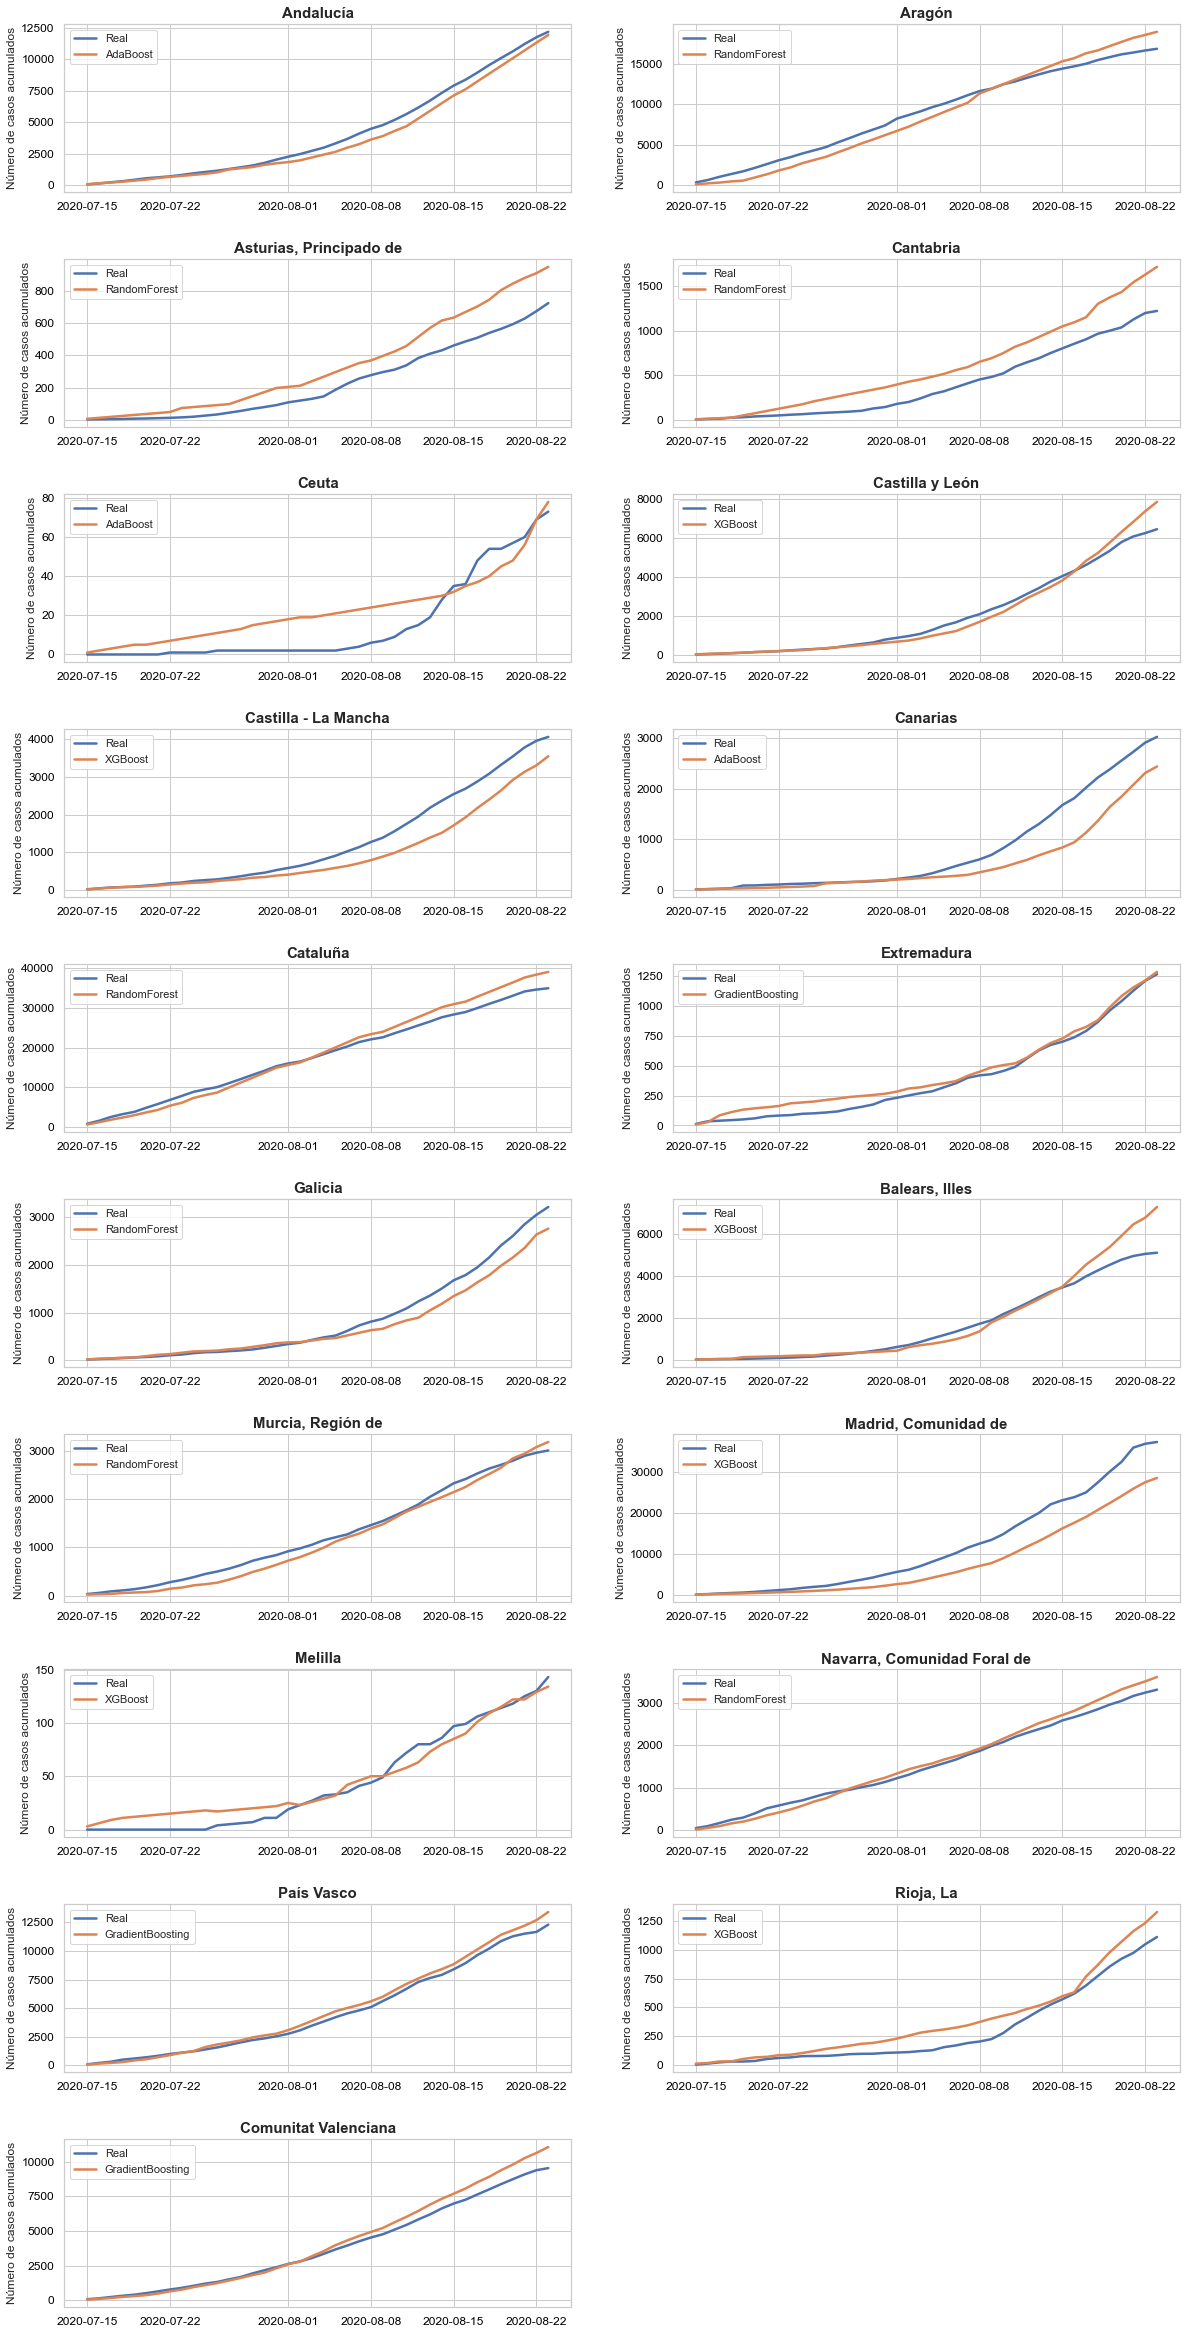

In [74]:
plot_best_model (predict_rfr_tune_grid,
                  predict_xgbr_tune_grid, 
                  models_predict_04['GB'],
                  models_predict_04['AB'], 
                  best_models,covid)
plt.savefig ('../imagenes/prediccion.jpg')

In [75]:
models_final=dict()
models_final['RF']= rfr_tune_grid
models_final['XGB']= xgbr_tune_grid
models_final['GB']= models_fit_04['GB']
models_final['AB']= models_fit_04['AB']


In [76]:
predict_models_final=dict()
predict_models_final['RF']= predict_rfr_tune_grid
predict_models_final['XGB']= predict_xgbr_tune_grid
predict_models_final['GB']= models_predict_04['GB']
predict_models_final['AB']= models_predict_04['AB']


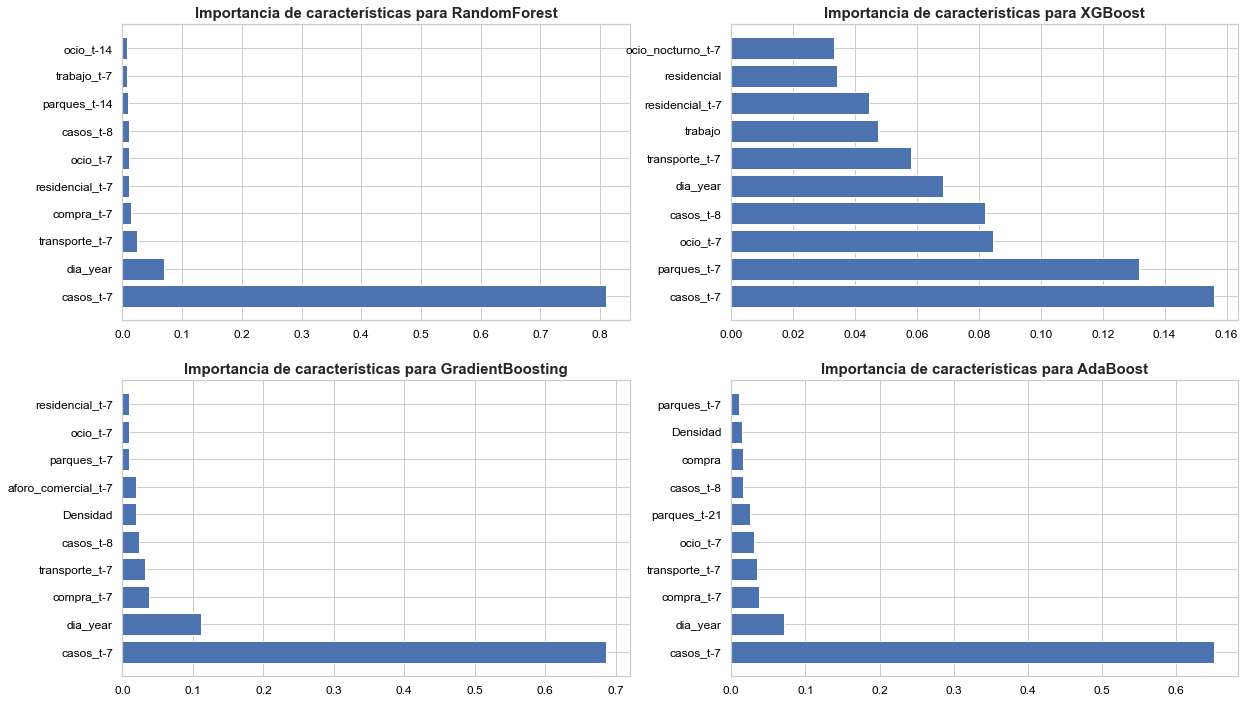

In [78]:
#VISUALIZACIÓN DE LAS CARACTERÍSTICAS MÁS IMPORTANTES PARA CADA MODELO
plt.figure(figsize=(20,12)) 
ax1=plt.subplot(221)
df=pd.DataFrame({'Features': dataset.drop(['fecha','casos'],axis=1).columns ,
              'Relevancia': models_final['RF'].feature_importances_}).sort_values('Relevancia', ascending=False)
df.reset_index (drop=True, inplace=True)
df=df[0:10]
ax1.set_title('Importancia de características para RandomForest',weight='bold', size=15)
ax1.barh(df['Features'], df['Relevancia'])
ax1.tick_params(axis='x', labelsize=12, labelcolor='black')
ax1.tick_params(axis='y', labelsize=12,  labelcolor='black')

ax1=plt.subplot(222)
df=pd.DataFrame({'Features': dataset.drop(['fecha','casos'],axis=1).columns ,
              'Relevancia': models_final['XGB'].feature_importances_}).sort_values('Relevancia', ascending=False)
df.reset_index (drop=True, inplace=True)
df=df[0:10]
ax1.set_title('Importancia de características para XGBoost',weight='bold', size=15)
ax1.barh(df['Features'], df['Relevancia'])
ax1.tick_params(axis='x', labelsize=12, labelcolor='black')
ax1.tick_params(axis='y', labelsize=12,  labelcolor='black')

ax1=plt.subplot(223)
df=pd.DataFrame({'Features': dataset.drop(['fecha','casos'],axis=1).columns ,
              'Relevancia': models_final['GB'].feature_importances_}).sort_values('Relevancia', ascending=False)
df.reset_index (drop=True, inplace=True)
df=df[0:10]
ax1.set_title('Importancia de características para GradientBoosting',weight='bold', size=15)
ax1.barh(df['Features'], df['Relevancia'])
ax1.tick_params(axis='x', labelsize=12, labelcolor='black')
ax1.tick_params(axis='y', labelsize=12,  labelcolor='black')

ax1=plt.subplot(224)
df=pd.DataFrame({'Features': dataset.drop(['fecha','casos'],axis=1).columns ,
              'Relevancia': models_final['AB'].feature_importances_}).sort_values('Relevancia', ascending=False)
df.reset_index (drop=True, inplace=True)
df=df[0:10]
ax1.set_title('Importancia de características para AdaBoost',weight='bold', size=15)
ax1.barh(df['Features'], df['Relevancia'])
ax1.tick_params(axis='x', labelsize=12, labelcolor='black')
ax1.tick_params(axis='y', labelsize=12,  labelcolor='black')

# Generación de resultados finales

In [80]:
#plot_best_model (predict_rfr_tune, models_predict_07['XGB'],models_predict_07['GB'],models_predict_07['AB'], best_models,covid)

df_result=covid.copy()
df_result_train=df_result[df_result['fecha'].isin (pd.date_range (train_ini,train_fin))]
df_result_test=df_result[df_result['fecha'].isin (pd.date_range (test_ini,test_fin))]

df = df_result_test.copy()

df['XGBoost']=round_int (predict_models_final['XGB'])
df['AdaBoost']=round_int (predict_models_final['AB'])
df['RandomForest']=round_int (predict_models_final['RF'])
df['GradientBoosting']=round_int (predict_models_final['GB'])


result_collection = {}

for ca in df['ccaa_iso'].unique():
    df_ca=df[df['ccaa_iso']==ca]
    model_for_ca=best_models[best_models['ccaa_iso']==ca]['Modelo'].values[0]
    df_ca['predict']= df_ca[model_for_ca]

    result_collection[ca]=df_ca

df_result_test =result_collection[0]
for i in range (1,19):
    df_result_test =pd.concat ([df_result_test,result_collection[i]],axis=0)

#df_result_test
df_result=pd.concat ([df_result_train, df_result_test], axis=0)
df_result.loc[df_result['predict'].isnull(),'predict']=df_result.loc[df_result['predict'].isnull(),'casos']
df_result['casos_acum']=df_result.groupby('ccaa_iso')['casos'].cumsum()
df_result['predict_acum']=df_result.groupby('ccaa_iso')['predict'].cumsum()

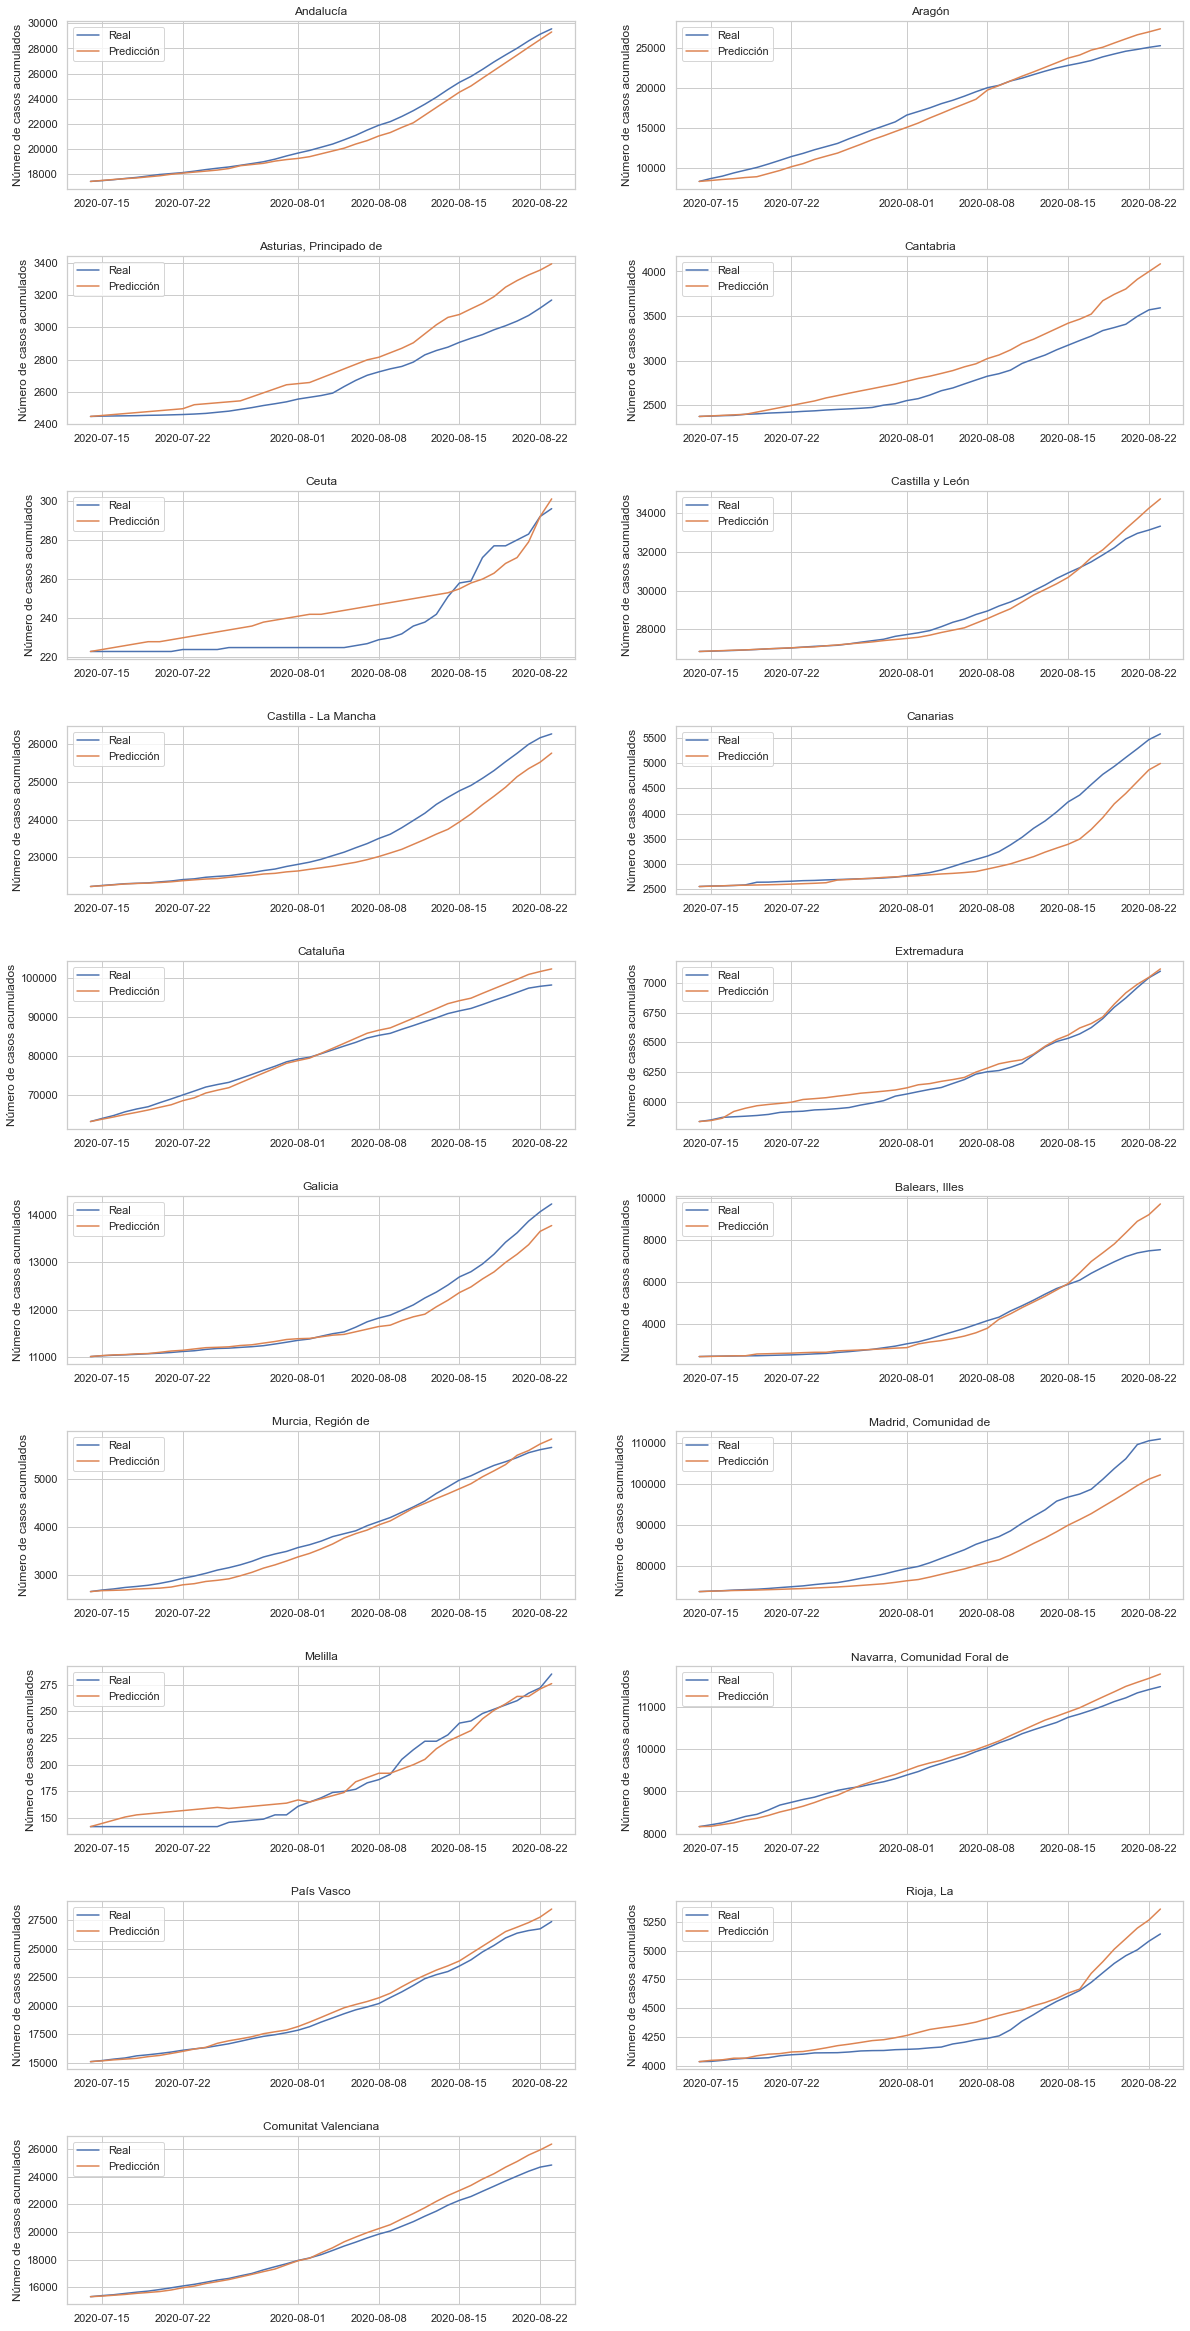

In [81]:
#Visualización dataset completo
df=df_result.copy()
df=df[df['fecha']>= pd.to_datetime('2020-07-14')]

n=df.ccaa_iso.nunique()
ncols=2
nfilas=math.ceil((n-ncols)/ncols)+1

#Definimos la grid para representación
fig= plt.figure(figsize=(20,42))
gs = fig.add_gridspec(nfilas, ncols,hspace=0.4)

#fig.suptitle('Predicción de casos por CA')
nf,nc=0,0

for ca in df['ccaa_iso'].unique():
    ax=fig.add_subplot(gs[nf,nc])
    
    x = df[df['ccaa_iso']== ca]['fecha']
    y1 = df[df['ccaa_iso']== ca]['casos_acum']
    y2 = df[df['ccaa_iso']== ca]['predict_acum']

    ax.plot (x, y1, label='Real')
    ax.plot (x, y2, label ='Predicción')

    ax.set_ylabel ('Número de casos acumulados')
    ax.set_title ( dict_nombre_iso[ccaa_iso_inv[ca]])
    ax.legend()
    if (nc == (ncols-1)): 
        nf=nf+1
        nc=0
    else:
        nc=nc+1
plt.savefig ('../imagenes/prediccion_ds_completo.jpg')

In [95]:
df_result_test[['casos','predict']].describe()


,casos,predict
count,760.000000,760.000000
mean,205.026316,209.343421
std,336.981872,318.348914
min,0.000000,-2.000000
25%,17.000000,19.000000
50%,78.500000,72.500000
75%,246.750000,274.000000
max,3472.000000,1791.000000


In [110]:
df_medias =df_result_test.groupby ('ccaa_iso')['casos','predict'].mean()
df_medias.rename (columns={'casos': 'media_casos', 'predict':'media_predict'}, inplace=True)
df_medias

,media_casos,media_predict
ccaa_iso,,
0,304.275,298.025
1,421.100,473.425
2,18.100,23.725
3,30.475,42.825
4,1.825,1.950
5,161.325,196.450
6,101.425,88.650
7,75.775,61.100
8,874.225,977.125


In [111]:
df_max=df_result_test.groupby ('ccaa_iso')['ccaa_nombre','casos','predict'].max()
df_max.rename (columns={'casos': 'max_casos', 'predict':'max_predict'}, inplace=True)
df_max

,ccaa_nombre,max_casos,max_predict
ccaa_iso,,,
0,Andalucía,615,623
1,Aragón,842,1139
2,Principado de Asturias,50,59
3,Cantabria,89,150
4,Ceuta,12,13
5,Castilla y León,453,552
6,Castilla - La Mancha,239,280
7,Canarias,209,274
8,Cataluña,1137,1295


In [114]:
df1=pd.concat ([df_max, df_medias], axis=1)
df1['diff_media']=df1['media_casos']-df1['media_predict']
df1['diff_max']=df1['max_casos']-df1['max_predict']
df1

,ccaa_nombre,max_casos,max_predict,media_casos,media_predict,diff_media,diff_max
ccaa_iso,,,,,,,
0,Andalucía,615,623,304.275,298.025,6.250,-8
1,Aragón,842,1139,421.100,473.425,-52.325,-297
2,Principado de Asturias,50,59,18.100,23.725,-5.625,-9
3,Cantabria,89,150,30.475,42.825,-12.350,-61
4,Ceuta,12,13,1.825,1.950,-0.125,-1
5,Castilla y León,453,552,161.325,196.450,-35.125,-99
6,Castilla - La Mancha,239,280,101.425,88.650,12.775,-41
7,Canarias,209,274,75.775,61.100,14.675,-65
8,Cataluña,1137,1295,874.225,977.125,-102.900,-158


# ALMACENAMIENTO DE MODELOS FINALES



In [82]:
import joblib

joblib.dump (models_final['RF'], 'RF_fit.joblib')
joblib.dump (models_final['XGB'], 'XGB_fit.joblib')
joblib.dump (models_final['GB'], 'GB_fit.joblib')
joblib.dump (models_final['AB'], 'AB_fit.joblib')

['AB_fit.joblib']

# Guardamos en fichero

In [84]:
df_result.to_csv('COVID_result.csv')